<a href="https://colab.research.google.com/github/mdeniz1/datascienceprojects/blob/main/Predictive_Modeling_of_House_Prices_Using_LightGBM_and_Ridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook utilizes the [House Sales in King County, USA data](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction) to construct two predictive models: Ridge and LightGBM, with the aim of forecasting house prices.

The initial exploration involved determining whether the dataset exhibited time-series characteristics, ultimately concluding that it did not. Subsequently, I established a baseline for both the Ridge and LightGBM models. To enhance the model's performance, I engineered three new features derived from existing ones.

To improve the data quality, I employed the IRQ range to identify and eliminate outliers. Following this, I conducted a train-test split and standardized the data. Additionally, I conducted an investigation into multicollinearity among the predictor features in the training dataset. I then used lofo importance values to extract important features for the model.

The modeling phase involved training four distinct Ridge models with polynomial features, and it was determined that a polynomial degree of 3 yielded the best performance. Following that, I proceeded to train multiple LightGBM models, incorporating hyperparameter tuning via RandomizedSearchCV and utilizing KFOLD validation for robust evaluation.


Finally, I employed shap summary plot to interpret the results of the best-performing LightGBM model.






In [ ]:
pip install lightgbm


In [ ]:
pip install lofo-importance


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
import joblib
import shap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
import seaborn as sns




In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = r'/content/drive/My Drive/kc_house_data.csv'
df = pd.read_csv(path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

There are not any null values in the dataset.

In [ ]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


Since there is date information available, I would like to investigate whether there is any recurring pattern or periodic fluctuation in the price.

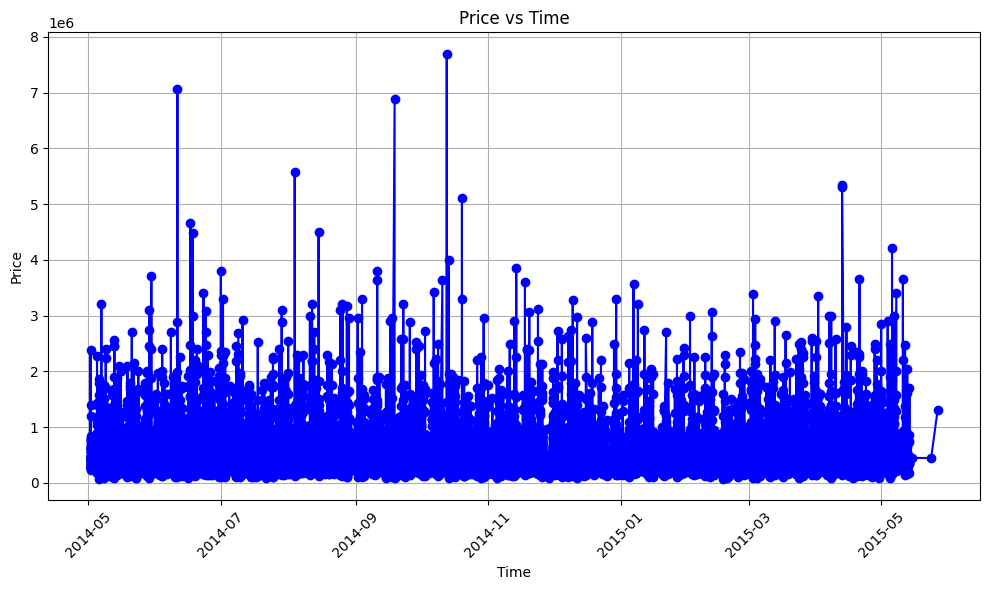

In [ ]:
df['date'] = pd.to_datetime(df['date'].str.split('T').str[0], format='%Y%m%d')
df.sort_values(by='date', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['price'], marker='o', linestyle='-', color='b')
plt.title('Price vs Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()







It appears that there isn't a discernible pattern in the data, but I'd like to examine the autocorrelation function (ACF) plot for the target variable, which in this case is the price.

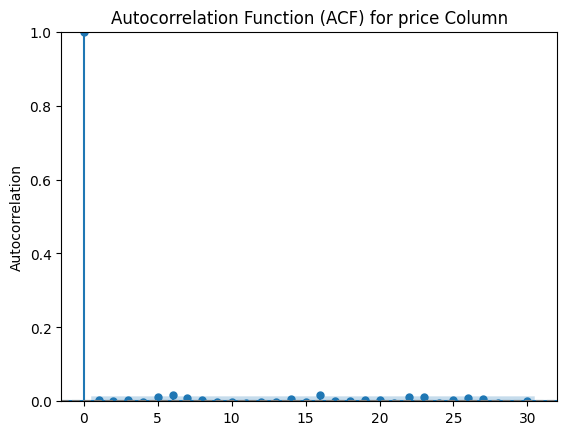

In [ ]:

fig, ax = plt.subplots()
plot_acf(df['price'], lags=30, ax=ax)
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

ax.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('Autocorrelation')
plt.title(f'Autocorrelation Function (ACF) for price Column')
plt.show()


It seems that the autocorrelation function (ACF) for all lags up to 30 days is close to 0, and the price-time plot doesn't show any apparent time-based patterns or trends in the price. Given these observations, it's reasonable not to treat the dataset as a time series.

In [ ]:
df.drop('date', axis=1, inplace=True)

In [ ]:
df.drop('id', axis=1, inplace=True)

In [ ]:
df.sort_index(inplace=True)


BASELINE RIDGE REGRESSOR

Before proceeding with further feature selection and data processing, I would like to establish baseline performance scores for both the Ridge and LightGBM regression models, as recommended in the task document. I evaluate the models' performance primarily based on Cross Validation RMSE scores, which provide a quantitative measure of predictive accuracy. However, to enhance interpretability, I also include the Mean Absolute Percentage Error (MAPE) metric. MAPE offers valuable insights into how accurately the model predicts real values, making the evaluation more understandable and meaningful.






In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

ridge_model = Ridge(alpha=1.0)

ridge_model.fit(X_train, y_train)

y_train_pred = ridge_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))


cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-cv_scores.mean())

y_test_pred = ridge_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))


mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"RMSE on Training Set: {rmse_train:.2f}")
print(f"RMSE on Cross-Validation Set: {rmse_cv:.2f}")
print(f"RMSE on Test Set: {rmse_test:.2f}")
print(f"Mean Absolute Percentage Error on Training Set: {mape_train:.2f}%")
print(f"Mean Absolute Percentage Error on Test Set: {mape_test:.2f}%")


RMSE on Training Set: 199892.49
RMSE on Cross-Validation Set: 200354.43
RMSE on Test Set: 212467.11
Mean Absolute Percentage Error on Training Set: 25.49%
Mean Absolute Percentage Error on Test Set: 25.63%


It's clear that the baseline model's high RMSE score of 212,000 is quite substantial, particularly when considering that the target feature has a median value of 450,000. To address this issue, we will explore additional preprocessing steps, conduct feature selection, and perform hyperparameter tuning to determine if we can reduce the RMSE on the test dataset. This iterative approach aims to enhance the model's accuracy and predictive performance

BASELINE LIGHTGBM REGRESSOR

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


lgb_model = lgb.LGBMRegressor()


lgb_model.fit(X_train, y_train)


y_train_pred = lgb_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))


cv_scores = -cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(cv_scores.mean())

y_test_pred = lgb_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100



In [ ]:

print(f"RMSE on Training Set: {rmse_train:.2f}")
print(f"RMSE on Cross-Validation Set: {rmse_cv:.2f}")
print(f"RMSE on Test Set: {rmse_test:.2f}")
print(f"Mean Absolute Percentage Error on Training Set: {mape_train:.2f}%")
print(f"Mean Absolute Percentage Error on Test Set: {mape_test:.2f}%")


RMSE on Training Set: 89509.25
RMSE on Cross-Validation Set: 122478.50
RMSE on Test Set: 125589.37
Mean Absolute Percentage Error on Training Set: 11.58%
Mean Absolute Percentage Error on Test Set: 13.39%


Indeed, the baseline LightGBM regressor has yielded a significant reduction in the RMSE score, nearly halving it when compared to the baseline Ridge model. This outcome is expected, primarily because the dataset contains absolute outliers, and Gradient Boosting Machine (GBM) models, like LightGBM, are resilient to outliers, unlike linear regression models. Additionally, GBM models are known to excel in cases where there are non-linear patterns in the data.

It's worth noting that the baseline LightGBM model shows a slight overfitting tendency, as indicated by the cross-validation score being approximately 30% higher than the training score. However, it's encouraging that the test score remains relatively close to the cross-validation score.

Alright! It's now time to delve deeper into working on the data.


## Feature Engineering and Data Preprocessing

In [ ]:
# a reminder on how our data looks like
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,age
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,98077.94,47.56,-122.21,1986.55,12768.46,0.02,43.99
std,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,53.51,0.14,0.14,685.39,27304.18,0.14,29.37
min,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,98001.00,47.16,-122.52,399.00,651.00,0.00,0.00
25%,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00,0.00,18.00
50%,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00,0.00,40.00
75%,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,98118.00,47.68,-122.12,2360.00,10083.00,0.00,64.00
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,98199.00,47.78,-121.31,6210.00,871200.00,1.00,115.00


The "yr_renovated" feature raises suspicion due to its notably high standard deviation and the fact that its minimum, 25th percentile, and median values are all zeros. To gain a better understanding of this feature, I'll start by examining its value counts, and based on that, I'll determine how or if we should utilize it in our analysis.

In [ ]:
df['yr_renovated'].value_counts()

0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

The vast majority of the dataset comprises non-renovated apartments, with some having no renovation at all. To simplify matters, I'll transform this feature into a binary one using the following strategy:

If the value is 0, signifying no renovation, I will assign it as 0.
If the renovation year precedes 2000, it will also be assigned a value of 0.
Otherwise, I will assign a value of 1.

In [ ]:
df['renovated'] = df['yr_renovated'].apply(lambda x: 0 if x < 2000 else 1)

df.drop(columns=['yr_renovated'], inplace=True)


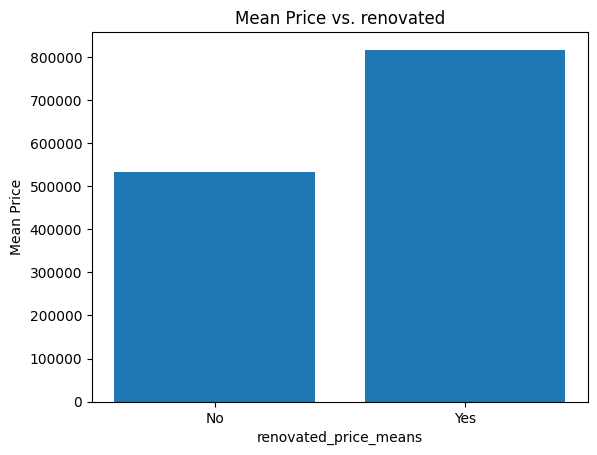

In [ ]:
renovated_price_means = df.groupby('renovated')['price'].mean()

plt.bar(renovated_price_means.index, renovated_price_means.values)
plt.xlabel('renovated_price_means')
plt.ylabel('Mean Price')
plt.title('Mean Price vs. renovated')
plt.xticks(renovated_price_means.index, ['No', 'Yes'])  # Label the x-axis
plt.show()


With the new column in place, it appears that renovated apartments have a price that is approximately 60% higher than that of non-renovated apartments. This suggests that the newly created feature could be a valuable addition to feed into the model.

Regarding the "waterfront" feature, its low standard deviation of only 0.01 indicates that the feature values exhibit minimal variation. While having a feature with little variability isn't typically desirable, we should conduct further investigation before deciding whether to delete it.

In [ ]:
df['waterfront'].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

only 1% of the total entries have value 1. Before deciding to delete the feature, let's check if waterfront properties tend to have higher prices.

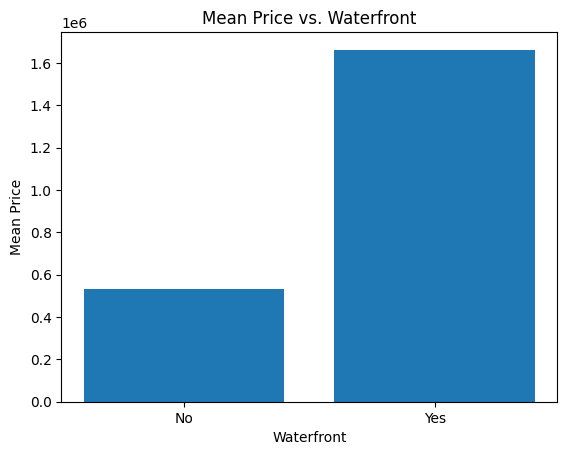

In [ ]:
waterfront_price_means = df.groupby('waterfront')['price'].mean()

plt.bar(waterfront_price_means.index, waterfront_price_means.values)
plt.xlabel('Waterfront')
plt.ylabel('Mean Price')
plt.title('Mean Price vs. Waterfront')
plt.xticks(waterfront_price_means.index, ['No', 'Yes'])  # Label the x-axis
plt.show()


It appears that having a waterfront house significantly increases the price, so I'll retain the column despite its low variability.

The "yr_built" column would be better represented as the apartment's age, which can be calculated by subtracting the year built from 2015, as this is the publication date of the data.

In [ ]:
df['age']=2015-df['yr_built']
df.drop('yr_built', axis=1, inplace=True)

## Outlier Detection

Now, it's time to inspect outliers. I'll utilize box plots to identify any outliers based on the interquartile range (IQR).

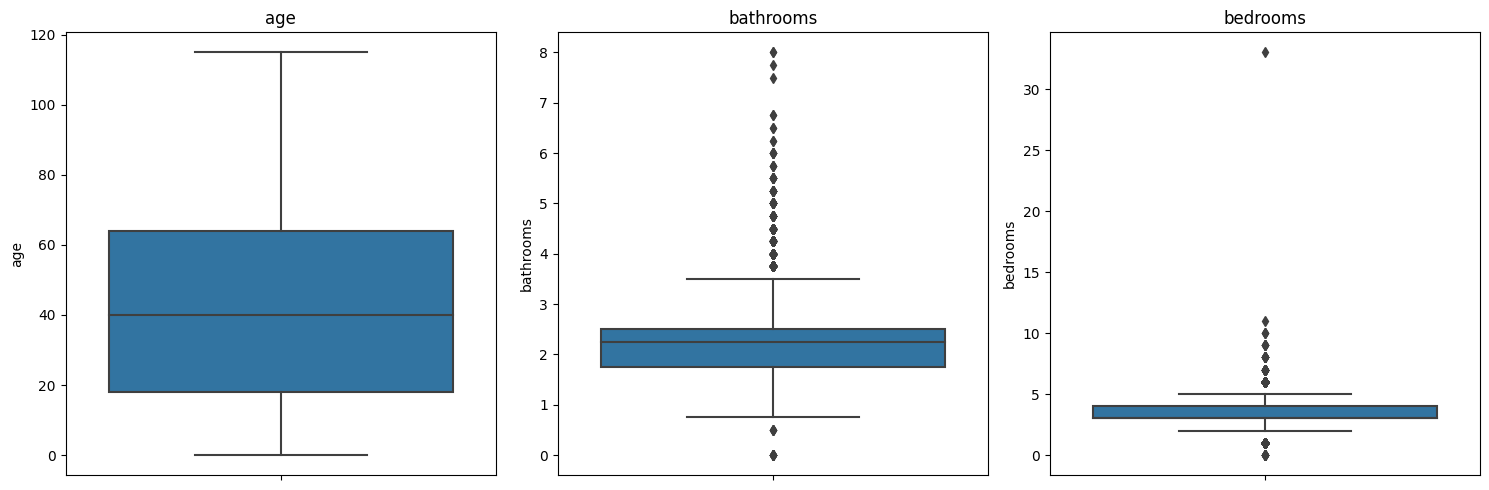

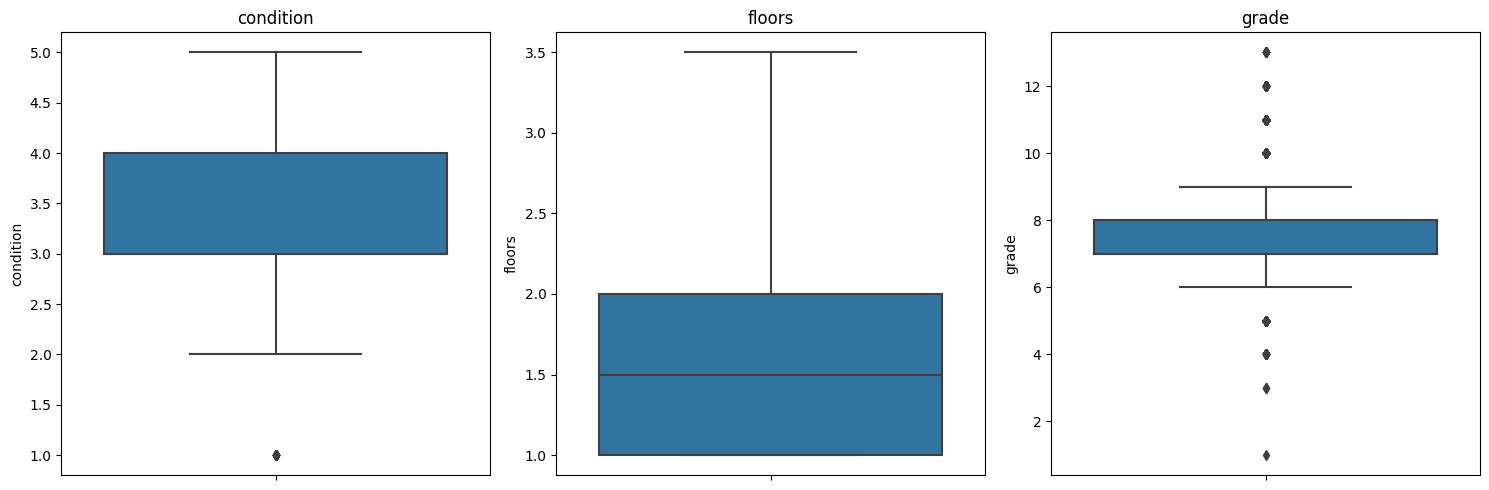

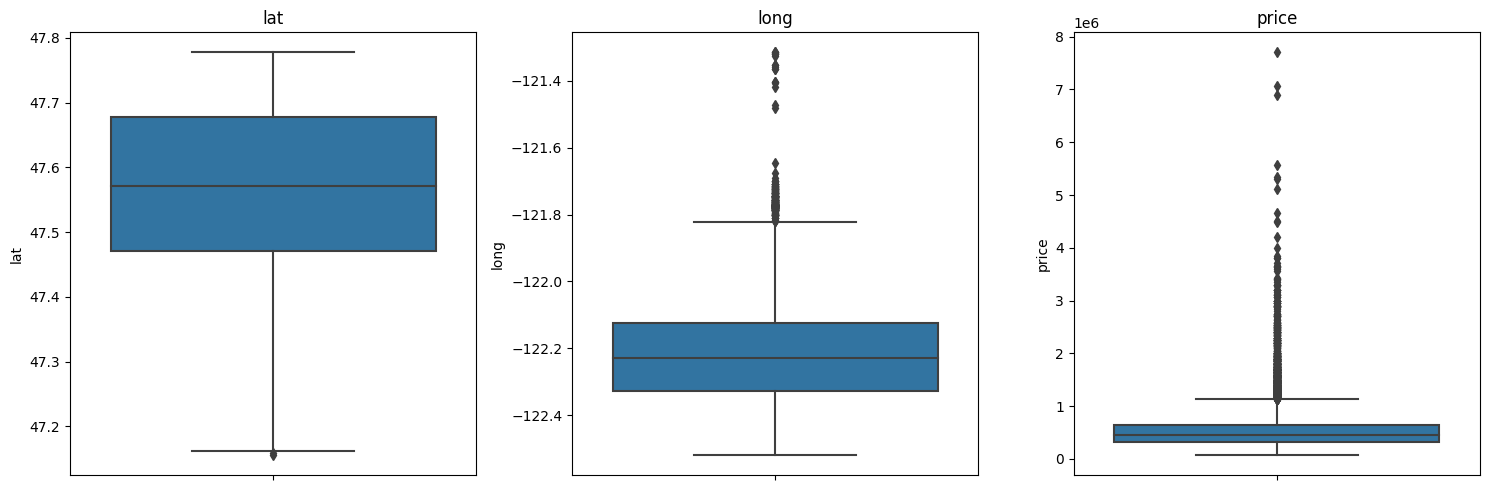

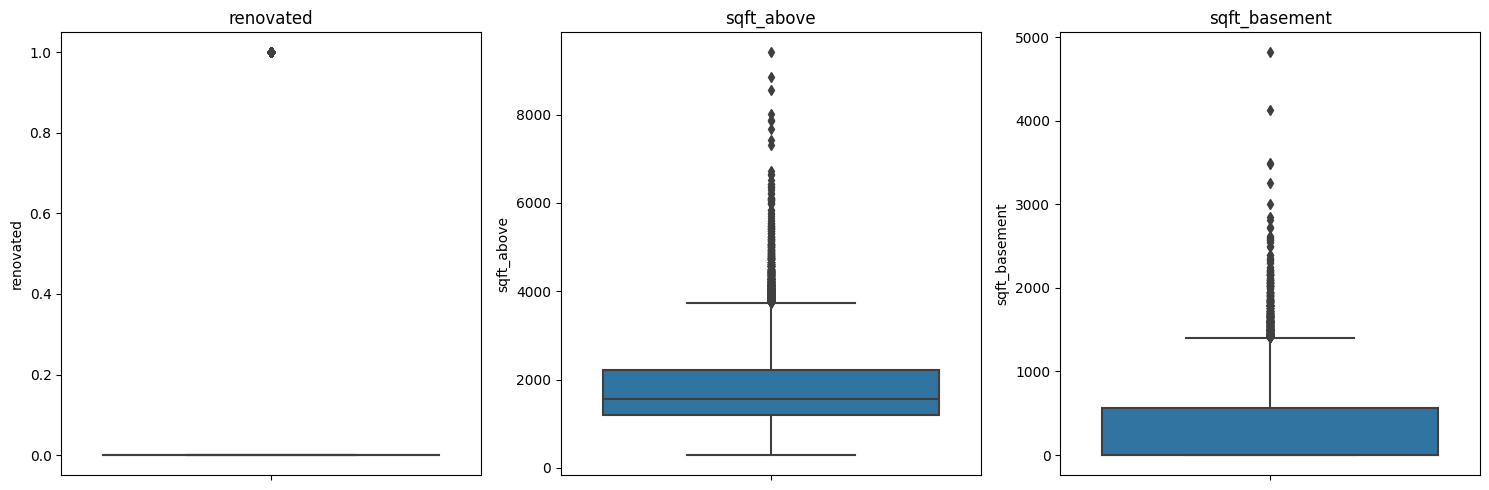

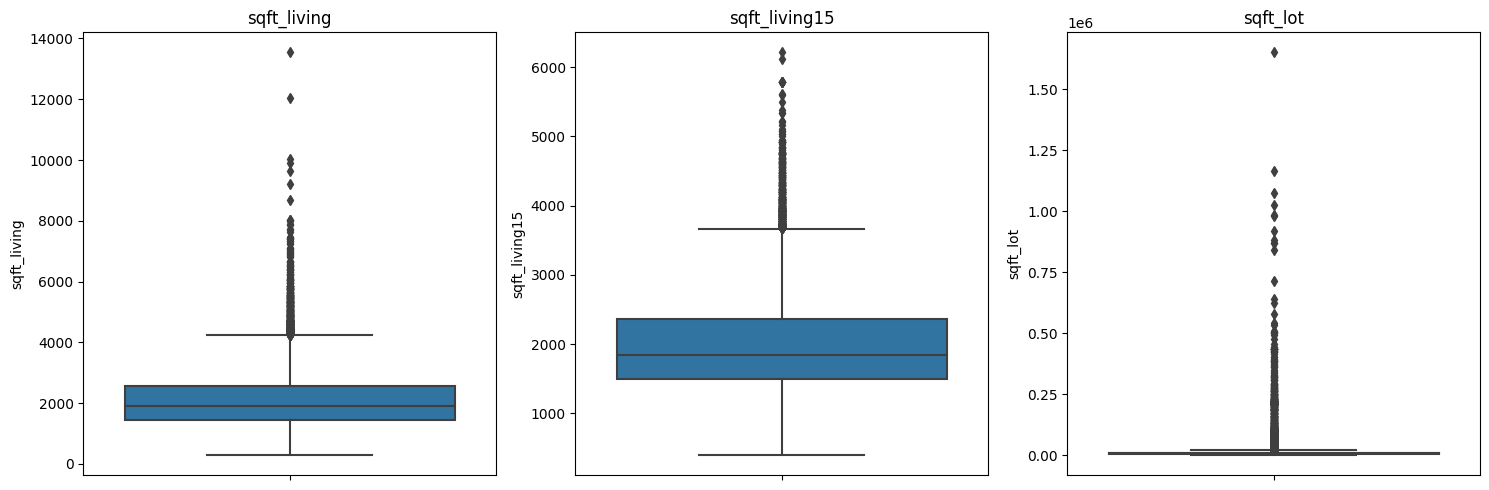

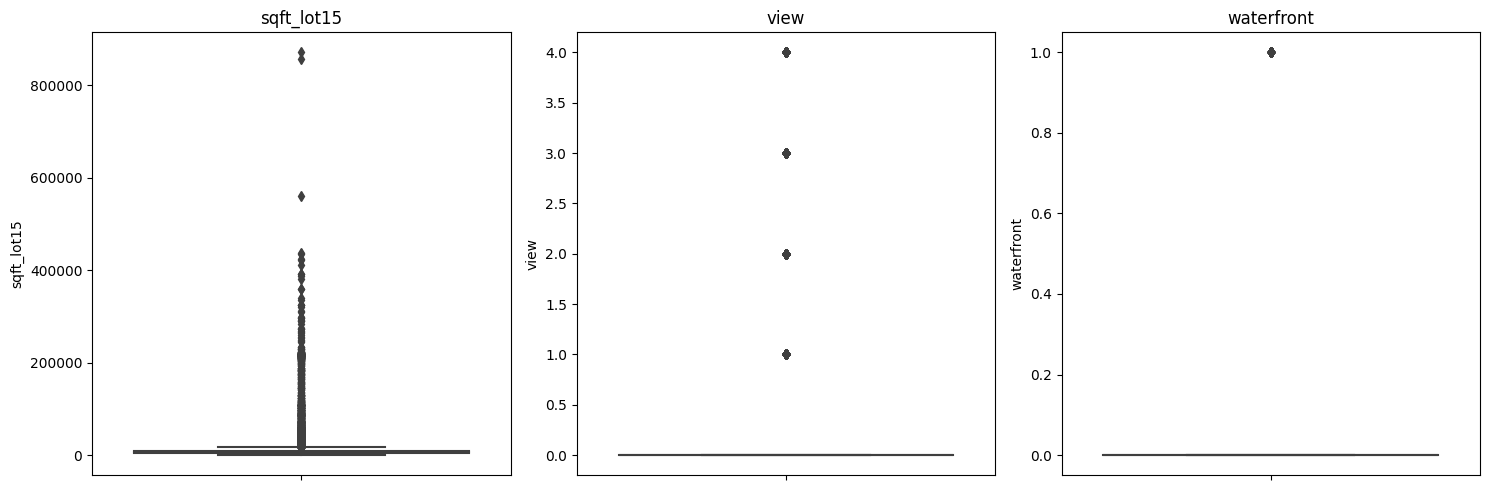

In [ ]:

features_to_plot = df.columns.difference(['zipcode'])

feature_groups = [features_to_plot[i:i+3] for i in range(0, len(features_to_plot), 3)]

for group in feature_groups:
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(group):
        plt.subplot(1, len(group), i+1)
        sns.boxplot(data=df, y=feature)
        plt.title(feature)
    plt.tight_layout()
    plt.show()


As most features have outliers, I will apply Tukey's fences for outlier detection and removal. This method is effective in identifying and dealing with extreme data points, ensuring our analysis is robust and accurate

In [ ]:
df2=df.copy()

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  zipcode        21613 non-null  int64  
 13  lat            21613 non-null  float64
 14  long           21613 non-null  float64
 15  sqft_living15  21613 non-null  int64  
 16  sqft_lot15     21613 non-null  int64  
 17  renovated      21613 non-null  int64  
 18  age   

In [ ]:
columns_to_exclude = ['zipcode','renovated','waterfront','view']
for col in df2.columns:
    if col not in columns_to_exclude:
      q1 = df2[col].quantile(0.25)
      q3 = df2[col].quantile(0.75)
      iqr = q3 - q1
      a = q1 - 1.5 * iqr
      b = q3 + 1.5 * iqr
      outliers = df2[(df[col] < a) | (df2[col] > b)]
      outlier_index = outliers.index
      df2.drop(outlier_index, inplace=True)
df2 = df2.reset_index(drop=True)


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15368 entries, 0 to 15367
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15368 non-null  float64
 1   bedrooms       15368 non-null  int64  
 2   bathrooms      15368 non-null  float64
 3   sqft_living    15368 non-null  int64  
 4   sqft_lot       15368 non-null  int64  
 5   floors         15368 non-null  float64
 6   waterfront     15368 non-null  int64  
 7   view           15368 non-null  int64  
 8   condition      15368 non-null  int64  
 9   grade          15368 non-null  int64  
 10  sqft_above     15368 non-null  int64  
 11  sqft_basement  15368 non-null  int64  
 12  zipcode        15368 non-null  int64  
 13  lat            15368 non-null  float64
 14  long           15368 non-null  float64
 15  sqft_living15  15368 non-null  int64  
 16  sqft_lot15     15368 non-null  int64  
 17  renovated      15368 non-null  int64  
 18  age   

In [ ]:
#saving the processed df for future use

file_path = '/content/drive/My Drive/df2_housing_prediction'

df2.to_csv(path, index=False)



In [ ]:
path = '/content/drive/My Drive/df2_housing_prediction.csv'

df2 = pd.read_csv(path)

## Feature Selection With LOFO Importance Values

I will assess the contribution of different features in predicting the target column by utilizing LOFO (Leave-One-Feature-Out) importance values. To ensure there is no data leakage from the test set to the training set, I will exclusively employ the training set for feature selection.

I standardize the data before inputting it into LOFO and the models. I perform the standardization process separately for the training and test sets to prevent any data leakage.






In [ ]:


train_df, test_df = train_test_split(df2, test_size=0.10, random_state=42)


X_train = train_df.drop('price', axis=1)
y_train = train_df['price']
X_test = test_df.drop('price', axis=1)
y_test = test_df['price']

scaler_train = StandardScaler()

scaled_train= scaler_train.fit_transform(X_train)

df_scaled_train = pd.DataFrame(scaled_train, columns=X_train.columns)



scaler_test = StandardScaler()

scaled_test= scaler_test.fit_transform(X_test)

df_scaled_test = pd.DataFrame(scaled_test, columns=X_test.columns)






df_scaled_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
df_scaled_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)



In [ ]:
df_train_total = df_scaled_train.copy()

df_train_total['price'] = y_train


In [ ]:


cv = KFold(n_splits=10, shuffle=True, random_state=42)

dataset = Dataset(df=df_train_total, target='price', features=[col for col in df.columns if col != "price"])

lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_root_mean_squared_error")

importance_df = lofo_imp.get_importance()



In [ ]:
#saving df for future use

file_path = '/content/drive/My Drive/importance_df.csv'

importance_df.to_csv(file_path)  #


In [ ]:
file_path = '/content/drive/My Drive/importance_df.csv'
importance_df=pd.read_csv(file_path)

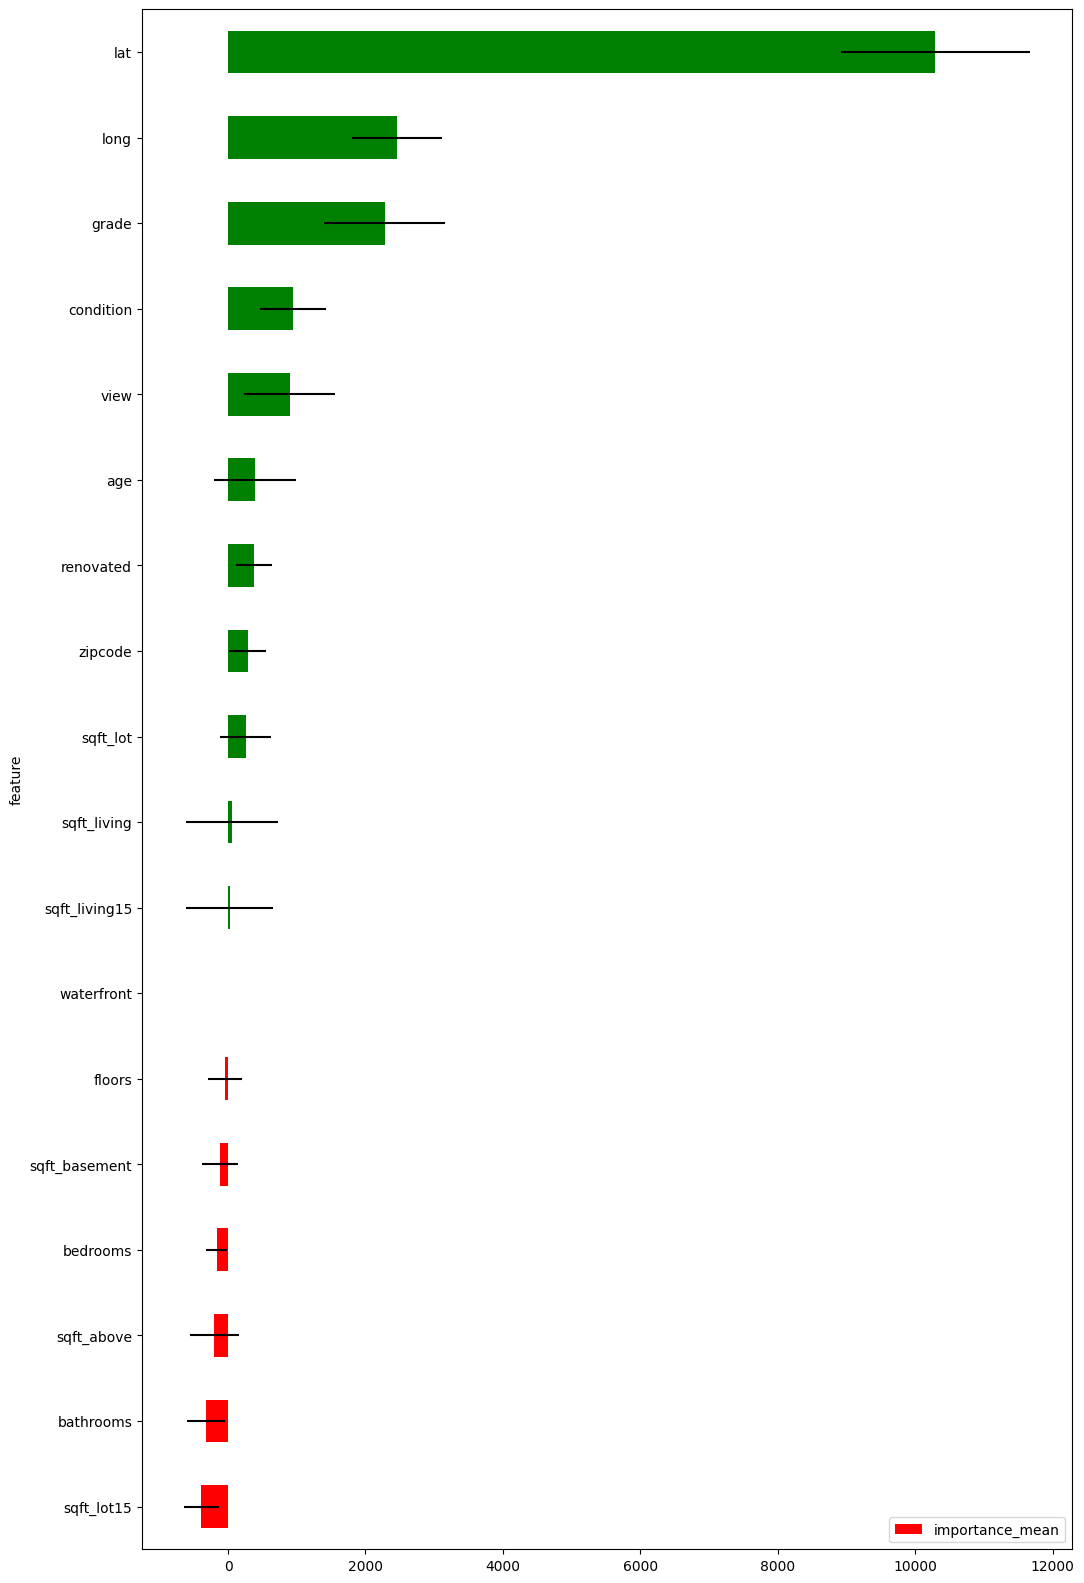

In [ ]:
plot_importance(importance_df, figsize=(12, 20))


In [ ]:
importance_df.head(20)

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3,val_imp_4,val_imp_5,val_imp_6,val_imp_7,val_imp_8,val_imp_9
4,lat,10293.72,1369.98,12256.63,8363.96,10416.60,10951.65,12523.61,9407.48,9427.89,11275.73,8570.90,9742.75
9,long,2454.26,653.50,2998.72,2644.97,1564.24,2063.28,3167.58,1690.04,2829.26,3537.74,2350.55,1696.20
17,grade,2276.86,878.74,3070.14,1046.15,2143.38,1822.63,3435.21,2833.72,2034.60,3547.93,1941.95,892.89
16,condition,938.35,480.31,808.20,337.26,1552.26,1466.12,1084.18,1430.04,331.28,755.77,1345.44,272.97
1,view,897.15,658.62,1877.26,844.44,886.92,1672.51,1354.37,157.07,-273.30,257.64,1377.79,816.78
7,age,388.21,596.82,1747.65,-164.30,1052.74,213.26,544.58,559.93,-334.31,2.67,-67.95,327.79
13,renovated,378.69,264.88,303.27,261.32,757.28,95.36,747.22,79.49,-0.92,372.01,625.79,546.04
10,zipcode,288.16,269.32,694.62,296.09,677.33,613.06,84.89,192.72,-55.01,78.29,311.85,-12.23
0,sqft_lot,255.44,369.68,308.97,-43.82,-268.74,641.62,1104.09,137.35,243.31,65.24,-3.04,369.43
6,sqft_living,53.42,670.43,-40.74,860.10,239.84,1054.44,-49.03,-560.35,-1227.94,652.86,-574.35,179.35


In this step, I remove the columns that have negative LOFO values.

In [ ]:

important_features = importance_df.loc[importance_df['importance_mean'] > 0, 'feature'].tolist()
print(important_features)
X_train_new = df_scaled_train[important_features]
X_test_new=df_scaled_test[important_features]


['lat', 'long', 'grade', 'condition', 'view', 'age', 'renovated', 'zipcode', 'sqft_lot', 'sqft_living', 'sqft_living15']


## Detection of Multicolinearity

Below, I will employ two methods - **Variance Inflation Factor (VIF)** and the **correlation matrix** - to assess whether there is multicollinearity among the independent variables. Detecting multicollinearity is crucial, especially when working with linear models.


In [ ]:
X_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            1537 non-null   float64
 1   long           1537 non-null   float64
 2   grade          1537 non-null   float64
 3   condition      1537 non-null   float64
 4   view           1537 non-null   float64
 5   age            1537 non-null   float64
 6   renovated      1537 non-null   float64
 7   zipcode        1537 non-null   float64
 8   sqft_lot       1537 non-null   float64
 9   sqft_living    1537 non-null   float64
 10  sqft_living15  1537 non-null   float64
dtypes: float64(11)
memory usage: 132.2 KB


In [ ]:
correlation_matrix = X_train_new.corr()

print(correlation_matrix)


                lat  long  grade  condition  view   age  renovated  zipcode  \
lat            1.00 -0.19   0.07       0.01  0.01  0.20       0.02     0.30   
long          -0.19  1.00   0.17      -0.06 -0.12 -0.41      -0.05    -0.63   
grade          0.07  0.17   1.00      -0.17  0.11 -0.45       0.03    -0.17   
condition      0.01 -0.06  -0.17       1.00  0.03  0.36      -0.08    -0.01   
view           0.01 -0.12   0.11       0.03  1.00  0.09       0.02     0.13   
age            0.20 -0.41  -0.45       0.36  0.09  1.00       0.13     0.35   
renovated      0.02 -0.05   0.03      -0.08  0.02  0.13       1.00     0.05   
zipcode        0.30 -0.63  -0.17      -0.01  0.13  0.35       0.05     1.00   
sqft_lot      -0.16  0.25  -0.05       0.14  0.02  0.08      -0.02    -0.25   
sqft_living   -0.02  0.21   0.59      -0.03  0.13 -0.26       0.05    -0.18   
sqft_living15 -0.03  0.32   0.56      -0.08  0.17 -0.28      -0.02    -0.28   

               sqft_lot  sqft_living  sqft_living15

While two pairs of variables exhibit moderately high correlation (around 0.6), this by itself does not necessarily indicate any issues. Therefore, let's examine the VIF (Variance Inflation Factor) values to identify any multicollinearity among multiple variables.






In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = X_train_new.columns
vif["vif_Factor"] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif


,features,vif_Factor
0,lat,1.18
1,long,1.90
2,grade,2.08
3,condition,1.22
4,view,1.09
5,age,1.91
6,renovated,1.06
7,zipcode,1.84
8,sqft_lot,1.25
9,sqft_living,2.12


No worries! There doesn't appear to be an issue with multicollinearity, as none of the independent variables have a VIF factor exceeding 4.

## Building Ridge regrossor with GridsearchCV

Below, I utilize GridSearchCV with two important parameters: alpha and solver. I initiate the trial with the original features of the data as inputs. Following that, I introduce polynomial features to enhance complexity and potentially achieve improved cross-validation results.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

params = {
    'alpha': [0.1, 1.0, 5, 7, 0.5, 0.9, 10.0],  # Different values for the regularization parameter alpha
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag'],  # Different solvers
}

ridge = Ridge()

# GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(ridge, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train_new, y_train)





GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 5, 7, 0.5, 0.9, 10.0],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']},
             scoring='neg_mean_squared_error')

In [ ]:
best_ridge = grid_search.best_estimator_


mean_cross_val_score = -grid_search.best_score_

train_pred = best_ridge.predict(X_train_new)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = best_ridge.predict(X_test_new)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

mape_train = np.mean(np.abs((y_train - train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - test_pred) / y_test)) * 100


print(f"best hyperparameters are {random_search2.best_params_}")

print(f"RMSE on Cross-Validation Set: {np.sqrt(mean_cross_val_score):.2f}")
print(f"RMSE on Cross-Validation Set: {train_rmse:.2f}")
print(f"RMSE on Test Set: {test_rmse:.2f}")
print(f"MAPE on Training Set: {mape_train:.2f}%")
print(f"MAPE on Test Set: {mape_test:.2f}%")


best hyperparameters are {'solver': 'sag', 'alpha': 0.6}
RMSE on Cross-Validation Set: 109921.11
RMSE on Cross-Validation Set: 109778.68
RMSE on Test Set: 108711.23
MAPE on Training Set: 20.30%
MAPE on Test Set: 21.16%


This represents a substantial improvement over the baseline Ridge model! It's notably outperforming the baseline LightGBM model. I'll now increase the model's complexity with polynomial feature to see if this leads to further enhancements in the test results.



More Complex Model with Degree-2 Polynomial Features

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

param_dist = {
    'alpha': [ 0.3, 0.4, 0.5, 0.6],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag'],
}

ridge2 = Ridge()

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train_new)
X_test_poly = poly.transform(X_test_new)

random_search2 = RandomizedSearchCV(ridge2, param_distributions=param_dist, n_iter=15, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

random_search2.fit(X_train_poly, y_train)




RandomizedSearchCV(cv=3, estimator=Ridge(), n_iter=15, n_jobs=-1,
                   param_distributions={'alpha': [0.3, 0.4, 0.5, 0.6],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sag']},
                   scoring='neg_mean_squared_error')

In [ ]:

best_ridge2 = random_search2.best_estimator_

mean_cross_val_score2 = -random_search2.best_score_

train_pred = best_ridge2.predict(X_train_poly)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = best_ridge2.predict(X_test_poly)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
mape_train = np.mean(np.abs((y_train - train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - test_pred) / y_test)) * 100

print(f"best hyperparameters are {random_search2.best_params_}")
print(f"RMSE on Cross-Validation Set: {np.sqrt(mean_cross_val_score2):.2f}")
print(f"RMSE on Cross-Validation Set: {train_rmse:.2f}")
print(f"RMSE on Test Set: {test_rmse:.2f}")
print(f"MAPE on Training Set: {mape_train:.2f}%")
print(f"MAPE on Test Set: {mape_test:.2f}%")


best hyperparameters are {'solver': 'sag', 'alpha': 0.6}
RMSE on Cross-Validation Set: 97541.52
RMSE on Cross-Validation Set: 96516.04
RMSE on Test Set: 96966.50
MAPE on Training Set: 17.71%
MAPE on Test Set: 18.90%


With the introduction of a more complex model using polynomial features of degree 2, we've seen significant improvements, with a 15% lower CV RMSE and similar scores between the training and CV sets. Given this positive outcome, it's certainly worth exploring the possibility of an even more complex model with polynomial features of degree 3 to further enhance predictive performance.






More Complex Model with Degree-2 Polynomial Features

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

param_dist = {
    'alpha': [0.5, 0.6, 0.7],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag'],  # Different solvers
}

ridge3 = Ridge()

poly = PolynomialFeatures(degree=3)
X_train_poly_3 = poly.fit_transform(X_train_new)
X_test_poly_3 = poly.transform(X_test_new)

random_search3 = RandomizedSearchCV(ridge3, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

random_search3.fit(X_train_poly_3, y_train)



RandomizedSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
                   param_distributions={'alpha': [0.5, 0.6, 0.7],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sag']},
                   scoring='neg_mean_squared_error')

In [ ]:
best_ridge3=random_search3.best_estimator_
train_pred = best_ridge3.predict(X_train_poly_3)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = best_ridge3.predict(X_test_poly_3)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
cross_val_score3=-random_search3.best_score_

mape_train = np.mean(np.abs((y_train - train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - test_pred) / y_test)) * 100

print(f"best hyperparameters are {random_search2.best_params_}")
print(f"RMSE on Cross-Validation Set: {cross_val_score3:.2f}")
print(f"RMSE on Cross-Validation Set: {train_rmse:.2f}")
print(f"RMSE on Test Set: {test_rmse:.2f}")
print(f"MAPE on Training Set: {mape_train:.2f}%")
print(f"MAPE on Test Set: {mape_test:.2f}%")


best hyperparameters are {'solver': 'sag', 'alpha': 0.6}
RMSE on Cross-Validation Set: 7722641605.78
RMSE on Cross-Validation Set: 80041.01
RMSE on Test Set: 82555.72
MAPE on Training Set: 14.30%
MAPE on Test Set: 15.46%


The degree 3 polynomial feature model has already demonstrated a substantial 23% reduction in CV RMSE, which is quite promising. Given this success, it makes sense to proceed with trying a degree 4 polynomial feature model to explore whether it can provide further improvements in predictive performance.

In [ ]:

model_path = '/content/drive/My Drive/ridge_degree_3_model.pkl'

joblib.dump(best_ridge3, model_path)


In [ ]:
model_path = '/content/drive/My Drive/ridge_degree_3_model.pkl'

loaded_ridge_model = joblib.load(model_path)


Trial 4: polynomial degree 4

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

param_dist = {
    'alpha': [0.5, 0.6, 0.7],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag'],
}


ridge4 = Ridge()

poly = PolynomialFeatures(degree=4)
X_train_poly_4 = poly.fit_transform(X_train_new)
X_test_poly_4 = poly.transform(X_test_new)

random_search4 = RandomizedSearchCV(ridge4, param_distributions=param_dist, n_iter=4, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

random_search4.fit(X_train_poly_4, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=Ridge(), n_iter=4, n_jobs=-1,
                   param_distributions={'alpha': [0.5, 0.6, 0.7],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sag']},
                   scoring='neg_mean_squared_error')

In [ ]:

best_ridge4=random_search4.best_estimator_
train_pred = best_ridge4.predict(X_train_poly_4)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = best_ridge4.predict(X_test_poly_4)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
cross_val_score3=-random_search3.best_score_
print("Best Hyperparameters:", random_search3.best_params_)
print("Mean Cross-Validation RMSE:", np.sqrt(cross_val_score3))
print("Best Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Best Hyperparameters: {'solver': 'lsqr', 'alpha': 0.7}
Mean Cross-Validation RMSE: 87878.5616961354
Best Train RMSE: 104288.34877113205
Test RMSE: 105430.08476294306


After experimenting with different polynomial degrees, it appears that the polynomial degree 3 model is the best-performing Ridge model. To summarize, this Ridge model produced a test RMSE of 82555.72 and a 15% MAPE (Mean Absolute Percentage Error). On average, the model's predictions deviate from the actual prices in the test set by approximately 15%.

### Hyperparameter Optimization for LightGBM using RandomizedCV

Using hyperparameter tuning strategies outlined in LightGBM [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html), I start by the most important hyperparameters of the model: **n_estimators**,
 **learning_rate**, **max_depth**, **num_leaves**, **min_data_in_leaf**

 **n_estimators** is the number of boosting trees and more trees bring better accuracy at the cost of more training time and problem of overfitting. I start with moderately high n_estimators with low **learning rates** as recommended in the document. LightGBM grows trees leaf wise instead of dept wise like xgboost. That is, using defaulth **max depth**(infinite) and controlling** num leaves** are recommended by some experienced [kagglers](https://www.amazon.com/Kaggle-Workbook-Self-learning-exercises-competitions/dp/1804611212/ref=sr_1_4?crid=2VSBU36M8Z7NT&keywords=kaggle+book&qid=1695297271&sprefix=kaggle+book%2Caps%2C183&sr=8-4). however, I still start by limiting the depth and choosing num leaves smaller than 2^max_depth again as adviced by the documentation.

In [ ]:


param_grid = {
    'n_estimators': [ 400, 500, 600],
    'learning_rate': [ 0.1, 0.15, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [ 6, 20, 80], #
    'min_data_in_leaf': [20, 30, 50],

}

lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid,
                                   n_iter=80, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

random_search.fit(X_train_new, y_train)



In [ ]:
best_estm = random_search.best_estimator_

y_train_pred = best_estm.predict(X_train_new)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_test_pred = best_estm.predict(X_test_new)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
cross_val_score=-random_search.best_score_

mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"best parameters: {random_search.best_params_}")

print(f"RMSE on Cross-Validation Set: {np.sqrt(cross_val_score):.2f}")
print(f"RMSE on train Set: {train_rmse:.2f}")
print(f"RMSE on Test Set: {test_rmse:.2f}")
print(f"MAPE on Training Set: {mape_train:.2f}%")
print(f"MAPE on Test Set: {mape_test:.2f}%")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
best parameters: {'num_leaves': 20, 'n_estimators': 400, 'min_data_in_leaf': 20, 'max_depth': 7, 'learning_rate': 0.1}
RMSE on Cross-Validation Set: 67577.71
RMSE on train Set: 49804.09
RMSE on Test Set: 66299.71
MAPE on Training Set: 8.87%
MAPE on Test Set: 12.01%


The results are quite impressive when compared to the baseline LightGBM model. The cross-validation score has significantly improved, decreasing by nearly 2-fold from 122,000 to 67,577. While the training score is lower, which was expected, it's not very far from the cross-validation result. This indicates that the tuned LightGBM model is performing well and has the potential to generalize effectively to new data. Let's tune further to gain a better performance


Second Trial


For the second trial, I have reduced the intervals around the best hyperparameter values in order to further fine-tune the model.

In [ ]:


param_grid = {
    'n_estimators': [ 350, 400, 450],
    'learning_rate': [0.05, 0.07, 0.1],
    'max_depth': [6, 7,8],
    'num_leaves': [ 20, 30, 40], #
    'min_data_in_leaf': [15, 20, 25 ],

}

lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1)

random_search2 = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid,
                                   n_iter=90, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

random_search2.fit(X_train_new, y_train)



In [ ]:
best_estm = random_search2.best_estimator_

y_train_pred = best_estm.predict(X_train_new)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_test_pred = best_estm.predict(X_test_new)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
cross_val_score=-random_search2.best_score_

mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"best parameters: {random_search2.best_params_}")

print(f"RMSE on Cross-Validation Set: {np.sqrt(cross_val_score):.2f}")
print(f"RMSE on train Set: {train_rmse:.2f}")
print(f"RMSE on Test Set: {test_rmse:.2f}")
print(f"MAPE on Training Set: {mape_train:.2f}%")
print(f"MAPE on Test Set: {mape_test:.2f}%")


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
best parameters: {'num_leaves': 30, 'n_estimators': 450, 'min_data_in_leaf': 25, 'max_depth': 8, 'learning_rate': 0.05}
RMSE on Cross-Validation Set: 67147.37
RMSE on train Set: 50956.99
RMSE on Test Set: 64769.97
MAPE on Training Set: 9.01%
MAPE on Test Set: 11.67%


Since the CV score slightly decreased in the second trial, I've decided to change my approach. I'm returning to the hyperparameters used in the first experiment and will now conduct a new experiment. In this experiment, I'll fix one parameter at a time in each trial to systematically explore the impact of individual hyperparameters on the model's performance.




Third Trial

In [ ]:


param_grid = {
    'n_estimators': [ 400],
    'learning_rate': [  0.08, 0.1, 0.12],
    'max_depth': [ 7],
    'num_leaves': [ 20, 30, 40, 50],
    'min_data_in_leaf': [15, 20, 25],

}

lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1)

random_search3 = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid,
                                   n_iter=36, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

random_search3.fit(X_train_new, y_train)



In [ ]:
best_estm = random_search3.best_estimator_

y_train_pred = best_estm.predict(X_train_new)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_test_pred = best_estm.predict(X_test_new)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
cross_val_score=-random_search3.best_score_

mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f"best parameters: {random_search3.best_params_}")

print(f"RMSE on Cross-Validation Set: {np.sqrt(cross_val_score):.2f}")
print(f"RMSE on train Set: {train_rmse:.2f}")
print(f"RMSE on Test Set: {test_rmse:.2f}")
print(f"MAPE on Training Set: {mape_train:.2f}%")
print(f"MAPE on Test Set: {mape_test:.2f}%")


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
best parameters: {'num_leaves': 20, 'n_estimators': 400, 'min_data_in_leaf': 25, 'max_depth': 7, 'learning_rate': 0.08}
RMSE on Cross-Validation Set: 67316.07
RMSE on train Set: 52217.58
RMSE on Test Set: 65429.80
MAPE on Training Set: 9.19%
MAPE on Test Set: 11.74%


After observing slightly worse CV results in the previous trials, I've made some adjustments. I've decided to increase the value of n_estimators to potentially enhance accuracy. Additionally, I'm introducing the bagging_fraction hyperparameter to help control overfitting and further fine-tune the model's performance. These changes aim to strike a better balance between bias and variance in the model.


Fourth Trial

In [ ]:


param_grid = {
    'n_estimators': [ 500, 550, 650],
    'learning_rate': [ 0.06, 0.08, 1],
    'num_leaves': [ 20, 30, 40, 50],
    'min_data_in_leaf': [ 20, 25, 30],
    'bagging_fraction': [0.7, 0.8, 1]

}

lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1)


random_search3 = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid,
                                   n_iter=100, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

random_search3.fit(X_train_new, y_train)



In [ ]:
best_estm = random_search3.best_estimator_

y_train_pred = best_estm.predict(X_train_new)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_test_pred = best_estm.predict(X_test_new)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
cross_val_score=-random_search3.best_score_

mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"best parameters: {random_search3.best_params_}")

print(f"RMSE on Cross-Validation Set: {np.sqrt(cross_val_score):.2f}")
print(f"RMSE on train Set: {train_rmse:.2f}")
print(f"RMSE on Test Set: {test_rmse:.2f}")
print(f"MAPE on Training Set: {mape_train:.2f}%")
print(f"MAPE on Test Set: {mape_test:.2f}%")


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
best parameters: {'num_leaves': 30, 'n_estimators': 500, 'min_data_in_leaf': 30, 'learning_rate': 0.06, 'bagging_fraction': 0.7}
RMSE on Cross-Validation Set: 67243.00
RMSE on train Set: 47542.37
RMSE on Test Set: 64741.37
MAPE on Training Set: 8.51%
MAPE on Test Set: 11.68%


The model performance has shown slight improvements, which is promising. To further enhance accuracy and control overfitting, I'm increasing the value of n_estimators even more while keeping the learning rates low. Additionally, I'm adjusting the bagging_fraction hyperparameter. These modifications are aimed at fine-tuning the model for better overall performance.






Fifth Trial

In [ ]:
param_grid = {
    'n_estimators': [ 600, 700, 800],
    'learning_rate': [0.05, 0.06],
    'num_leaves': [30, 35, 40],
    'min_data_in_leaf': [  25, 30, 35],
    'bagging_fraction': [0.6, 0.7]

}

lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1)


random_search5 = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid,
                                   n_iter=100, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

random_search5.fit(X_train_new, y_train)



In [ ]:
best_estm = random_search5.best_estimator_

y_train_pred = best_estm.predict(X_train_new)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_test_pred = best_estm.predict(X_test_new)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
cross_val_score=-random_search5.best_score_

mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"best parameters: {random_search5.best_params_}")

print(f"RMSE on Cross-Validation Set: {np.sqrt(cross_val_score):.2f}")
print(f"RMSE on train Set: {train_rmse:.2f}")
print(f"RMSE on Test Set: {test_rmse:.2f}")
print(f"MAPE on Training Set: {mape_train:.2f}%")
print(f"MAPE on Test Set: {mape_test:.2f}%")


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
best parameters: {'num_leaves': 30, 'n_estimators': 600, 'min_data_in_leaf': 25, 'learning_rate': 0.05, 'bagging_fraction': 0.6}
RMSE on Cross-Validation Set: 67221.61
RMSE on train Set: 47051.20
RMSE on Test Set: 64886.96
MAPE on Training Set: 8.43%
MAPE on Test Set: 11.73%


As the bagging_fraction appears to be decreasing, I'm going to reduce it further while simultaneously increasing the value of n_estimators. To complement this adjustment, I'm decreasing the learning rate (LR) as n_estimators increases. I'm also maintaining num_leaves at 30, and for min_data_in_leaf, I'll consider values of either 25 or 30, treating them as a bundle within the param_grid. These changes are designed to help fine-tune the model's parameters and improve its performance.


6'th Trial

In [ ]:
param_grid = {
    'n_estimators': [ 600, 650, 700],
    'learning_rate': [0.04, 0.05],
    'num_leaves': [30],
    'min_data_in_leaf': [ 25, 30],
    'bagging_fraction': [0.5, 0.6]

}

lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1)


random_search6 = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid,
                                   n_iter=24, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

random_search6.fit(X_train_new, y_train)



In [ ]:
best_estm = random_search6.best_estimator_

y_train_pred = best_estm.predict(X_train_new)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_test_pred = best_estm.predict(X_test_new)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
cross_val_score=-random_search6.best_score_

mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100


print(f"best parameters: {random_search6.best_params_}")

print(f"RMSE on Cross-Validation Set: {np.sqrt(cross_val_score):.2f}")
print(f"RMSE on train Set: {train_rmse:.2f}")
print(f"RMSE on Test Set: {test_rmse:.2f}")
print(f"MAPE on Training Set: {mape_train:.2f}%")
print(f"MAPE on Test Set: {mape_test:.2f}%")


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
best parameters: {'num_leaves': 30, 'n_estimators': 600, 'min_data_in_leaf': 25, 'learning_rate': 0.04, 'bagging_fraction': 0.5}
RMSE on Cross-Validation Set: 67108.17
RMSE on train Set: 49280.31
RMSE on Test Set: 64354.79
MAPE on Training Set: 8.80%
MAPE on Test Set: 11.54%


Achieving a CV score of 67,108 RMSE is the best result we've obtained after six trials. The test score is slightly lower at 64,344 RMSE. Additionally, the MAPE score of 11.54 is 30% lower than the best Ridge model, indicating that, on average, our model predicts values that are 11.5% away from the real values. This represents a significant improvement in predictive accuracy, and the model appears to be performing quite well.



# Interpretation of the Best LightGBM model with shap values.

I will generate a summary SHAP (SHapley Additive exPlanations) plot to provide an interpretation of which features are the most important for predicting house prices and how changes in these features impact the model's predictions.


In [ ]:
explainer = shap.Explainer(best_estm)
shap_values = explainer(X_train_new)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


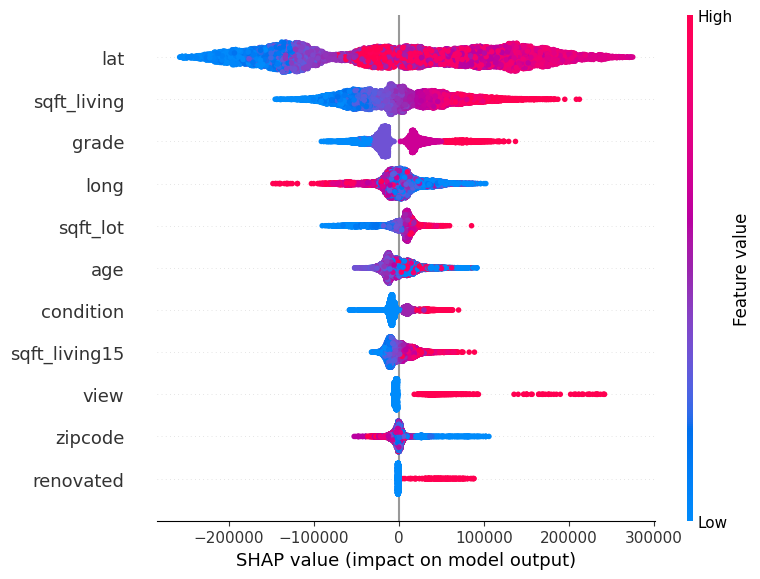

In [ ]:
shap.summary_plot(shap_values, X_train_new)


The following points represent some of the findings from the model:



*   Latitude is the crucial feature for our model. When combined with longitude, it defines the geographic location of an apartment, aligning with common knowledge about the housing market.



*   Increasing the latitude value leads to a rise in apartment prices.


*   The size of a house (sqft_living) is the second most important feature. An increase in the apartment's size significantly increases its price.



*   The grade of a house, representing the quality of workmanship and materials, also positively impacts the price. Higher quality corresponds to a higher price.



*  Age negatively affects the price; older buildings tend to have lower prices. However, its overall influence is less significant compared to location, size, and quality.


*   The condition of the house has a positive impact on the price, as expected.

*   Whether a house is renovated or not is the least important among the 11 features for predicting the target. Nevertheless, a renovated house does increase the apartment's price.


